In [7]:
#imports
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')

In [8]:
#read the data 
df = pd.read_csv("attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### Given the dataframe containing the employee data, clean it up by:
- Converting the target variable (Attrition) into a binary variable (0/1)
- Dropping columns that don't appear to be relevant / useful for analysis
- Handing missing / NaN values (in this case, there are none!)


In [9]:
df.drop(['Over18', 'StandardHours'], axis=1)
df['Attrition'].replace(to_replace = dict(Yes = 1, No = 0), inplace=True)

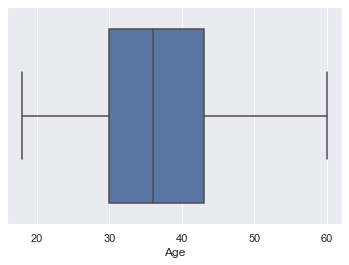

In [24]:
import seaborn as sns
sns.boxplot(x=df['Age'])

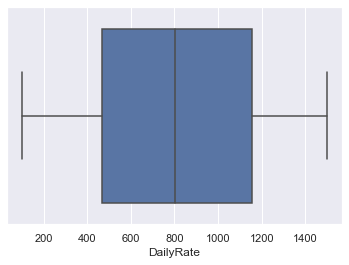

In [25]:
import seaborn as sns
sns.boxplot(x=df['DailyRate'])

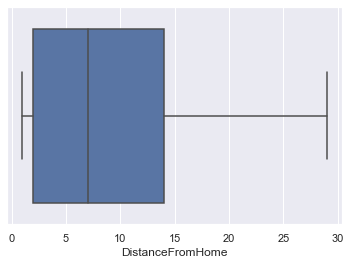

In [26]:
import seaborn as sns
sns.boxplot(x=df['DistanceFromHome'])

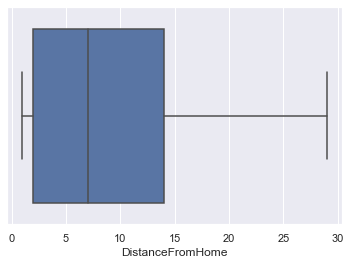

In [27]:
import seaborn as sns
sns.boxplot(x=df['DistanceFromHome'])